In [1]:
import sys
from pathlib import Path
import os

# ---------------------------------------------------------
# 1) path assoluto della directory dove sta questo script
HERE = Path.cwd()  # Use the current working directory in Jupyter Notebook

# 2) path assoluto della root del progetto (un livello sopra "scripts")
PROJECT_ROOT = HERE.parent

# 3) inserisco la root all’inizio di sys.path
sys.path.insert(0, str(PROJECT_ROOT))

In [17]:
import src.pipeline.Real_Pipeline as rp
import src.tensors.cokurt as ck
import tensorflow as tf

In [ ]:
params = {}

In [21]:
n_stocks = 50

In [108]:
dataset = rp.real_data_pipeline(batch_size=1, n_days=1200, n_days_out=5, n_stocks=n_stocks,# n_days_range=[250,250],
                      filename_returns ="../DATA/vanilla_returns_crsp-90-24.joblib",
                      filename_available_stocks ='../DATA/dtin_1200_dtout_5_shift_1_Db_crsp-90-24.pkl', 
                      datatime_range=['1995-01-01','2015-01-01'], return_generator=True, oos_covariance=False)

In [111]:
rin,rout = next(dataset())
rin,rout = rin[0],rout[0]

In [112]:
import scipy.linalg as la
import numpy as np

In [ ]:
ccore = tf.zeros((n_stocks, n_stocks, n_stocks, n_stocks), dtype=tf.float32)

cnt = 0
for rin,rout in dataset():
    if tf.reduce_any(tf.math.reduce_std(rout, axis=-1)==0):
        # Se ci sono colonne costanti, gestisci il caso
        continue
    rin,rout = rin[0],rout[0]
    r = np.concatenate((rin,rout),axis=-1)
    #r = r[:,np.random.permutation(r.shape[-1])]

    rin,rout = r[:,:r.shape[-1]//2], r[:,r.shape[-1]//2:]
    Sin = np.cov(rin,bias=True)
    Win = np.linalg.inv(la.sqrtm(Sin))

    Sout = np.cov(rout,bias=True)
    Wout = np.linalg.inv(la.sqrtm(Sout))
    
    zin = Win @ rin
    zout = Wout @ rout
    
    zin = tf.constant(zin, dtype=tf.float32)
    zout = tf.constant(zout, dtype=tf.float32)
    
    cnt += 1
    K = ck.cokurtosi_tensore_tf(zin, standardizza=True, dtype=tf.float32)
    G, U = ck.tucker_simmetrico_tf(K, r=None, dtype=tf.float32, return_fattori=True)
    Cout = ck.cokurtosi_tensore_tf(zout, standardizza=True, dtype=tf.float32)
    ccore += ck.core_da_fattori_tf(Cout, U)
    print(cnt,end='\r')
    if cnt>100000:
        break

ccore /= cnt


In [124]:
with open('../OUT/AOcore.pkl','wb') as f:
    import pickle
    pickle.dump(ccore.numpy(),f)

In [114]:
M = np.array([[ccore[i,i,j,j] for i in range(n_stocks)] for j in range(n_stocks)])

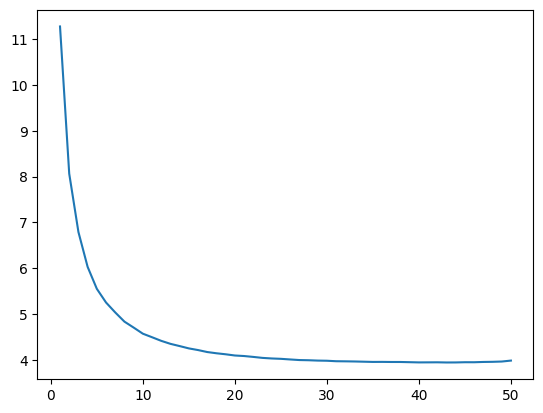

In [119]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1,n_stocks+1),M.diagonal())
#plt.yscale('log')
#plt.xscale('log')

In [131]:
M = np.array([ccore[i,i,j,h] for i in range(n_stocks) for j in range(i) for h in range(j)])

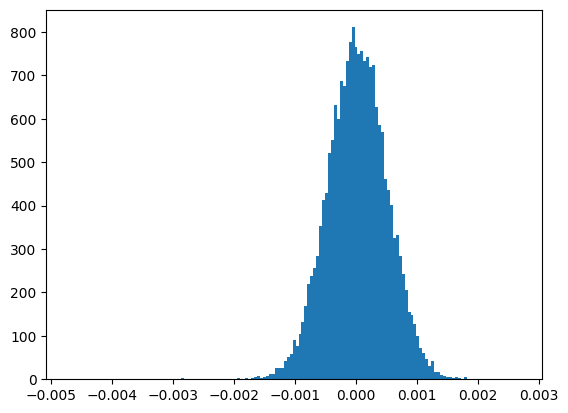

In [133]:
plt.hist(M,bins='auto');

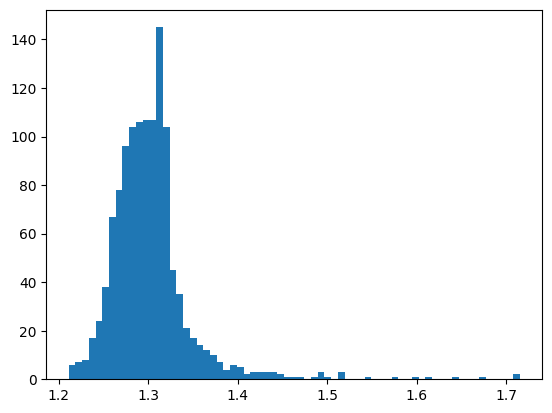

In [125]:
plt.hist(M[np.triu_indices(n_stocks,1)],bins='auto');

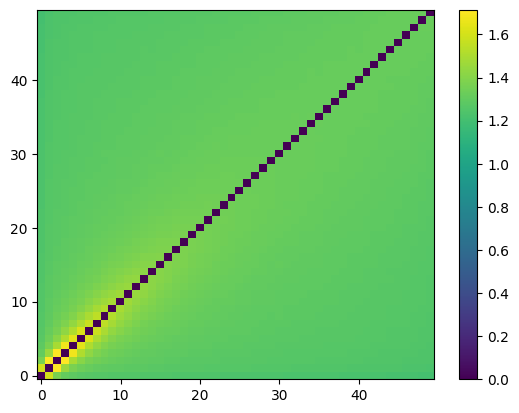

In [122]:
plt.imshow(M - np.diag(np.diag(M)),aspect='auto', origin='lower')
plt.colorbar()

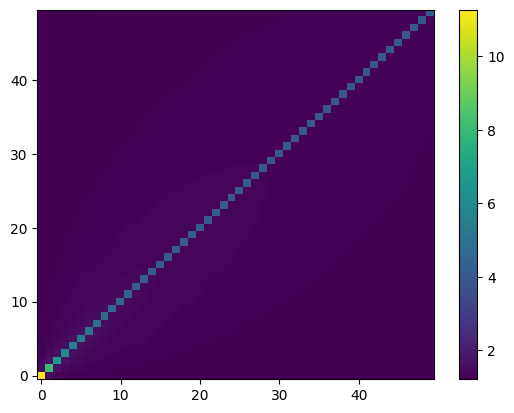

In [123]:
plt.imshow(M,aspect='auto', origin='lower')
plt.colorbar()

In [56]:
M = np.array([[G[i,i,j,j] for i in range(n_stocks)] for j in range(n_stocks)])

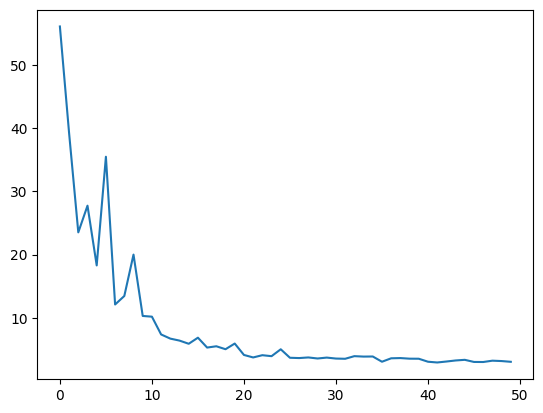

In [57]:
import matplotlib.pyplot as plt

plt.plot(M.diagonal())

In [29]:
dataset = rp.real_data_pipeline(batch_size=252, n_days=1200, n_days_out=1, n_stocks=n_stocks, n_days_range=[250,250], sequential=True,
                      filename_returns ="../DATA/vanilla_returns_crsp-90-24.joblib",
                      filename_available_stocks ='../DATA/dtin_1200_dtout_5_shift_1_Db_crsp-90-24.pkl',
                      datatime_range=['1995-01-01','2001-01-01'], return_generator=True, oos_covariance=False)

In [30]:
rin,rout = next(dataset())

In [31]:
rin.shape

(252, 50, 250)